In [29]:
!pip install -U langgraph langsmith

     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     ---------------------------------------- 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/137.9 kB ? eta -:--:--
   ---------------------------------------- 137.9/137.9 kB 8.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/351.9 kB ? eta -:--:--
   ---------------------------------------- 351.9/351.9 kB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/243.4 kB ? eta -:--:--
   ---------------------------------------- 243.4/243.4 kB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.9 kB ? eta -:--:--
   ---------------------------------------- 41.9/41.9 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
   ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
   ---------------------------------------- 0.0/495.6 kB ? eta -:--:--
   ----------------------------- --

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.0 requires langsmith<0.2.0,>=0.1.112, but you have langsmith 0.3.18 which is incompatible.


In [30]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model


In [1]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
from langchain.chat_models import init_chat_model

# Initialize the Mistral model
llm = init_chat_model("mistral-large-latest", model_provider="mistralai", api_key="ERbtRhtyGei4jY4AXn4QkrWSfGzlpLbP")


def chatbot(state: State):
    """
    Function to handle the chatbot node.
    It takes the current state and returns the AI response.
    """
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)


In [3]:
graph_builder.add_edge(START, "chatbot")

In [4]:
graph_builder.add_edge("chatbot", END)

In [5]:
graph = graph_builder.compile()

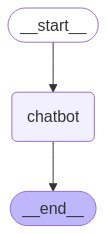

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Hello


Assistant: Hello! How can I assist you today?


User:  who are you? 


Assistant: I am a text-based AI model developed by the Mistral AI team. I'm here to help answer your questions, provide explanations, or just chat on a wide range of topics. I don't have personal experiences or emotions, but I'm designed to understand and generate human-like text based on the data I've been trained on (up until 2021). How can I assist you today?


User:  could you answer questions about sir issac newton 


Assistant: Absolutely, I'd be happy to help with questions about Sir Isaac Newton. Here are some key points about him:

### Basic Information
- **Full Name**: Isaac Newton
- **Birthdate**: January 4, 1643
- **Death**: March 31, 1727
- **Nationality**: English
- **Occupation**: Mathematician, physicist, astronomer, theologian, and author

### Major Contributions
1. **Laws of Motion**: Newton formulated the three laws of motion, which are fundamental to classical mechanics.
   - **First Law**: An object at rest stays at rest, and an object in motion stays in motion, unless acted upon by an unbalanced force.
   - **Second Law**: The force acting on an object is equal to its mass times its acceleration (F = ma).
   - **Third Law**: For every action, there is an equal and opposite reaction.

2. **Universal Law of Gravitation**: He described the universal law of gravitation, which states that any two objects in the universe attract each other with a force that is directly proportional to the

User:  exit


Goodbye!


In [ ]:
# Version  2 : Invoking a Tool with the model

In [1]:
from typing import Dict
from langchain.tools import tool

# Create a basic math tool
@tool("basic_math")
def basic_math_tool(operation: str, a: float, b: float) -> Dict:
    """
    A simple math tool that performs addition, subtraction, multiplication, and division.

    Args:
    - operation (str): The math operation to perform (add, subtract, multiply, divide).
    - a (float): First number.
    - b (float): Second number.

    Returns:
    - Dict: The result of the operation.
    """
    if operation == "add":
        return {"result": a + b}
    elif operation == "subtract":
        return {"result": a - b}
    elif operation == "multiply":
        return {"result": a * b}
    elif operation == "divide":
        if b == 0:
            return {"error": "Cannot divide by zero"}
        return {"result": a / b}
    else:
        return {"error": "Invalid operation"}


In [2]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

In [5]:
from langchain.schema import HumanMessage, AIMessage

def tool_node(state: State):
    """
    Node that invokes the math tool.
    """
    # Extract the last message correctly
    last_message = state["messages"][-1]
    
    # Check if the message is an instance of HumanMessage
    if isinstance(last_message, HumanMessage):
        message = last_message.content.lower()
    else:
        message = str(last_message)  # Fallback for unexpected types

    # Math tool invocation
    if "calculate" in message:
        try:
            _, operation, a, b = message.split()  # Extract parameters
            a, b = float(a), float(b)  # Convert to floats
            result = basic_math_tool(operation, a, b)

            response = f"Result: {result['result']}" if "result" in result else result['error']

        except (ValueError, IndexError):
            response = "Invalid input. Use format: 'calculate add 10 5'."

    else:
        response = "I can only calculate math operations."

    # Return the message in the correct format
    return {"messages": [AIMessage(content=response)]}


In [6]:
# Add the tool node to the graph
graph_builder.add_node("math_tool", tool_node)

def chatbot(state: State):
    """
    LLM node that handles the chatbot interactions.
    """
    # Convert messages to dictionaries with "role" and "content"
    llm_messages = [
        {
            "role": "user" if isinstance(msg, HumanMessage) else "ai",
            "content": msg.content
        }
        for msg in state["messages"]
    ]

    # Invoke the LLM with properly formatted messages
    response = llm.invoke(llm_messages)

    # Return the AI's response
    return {"messages": [AIMessage(content=response)]}


In [7]:
# Add LLM node
graph_builder.add_node("chatbot", chatbot)

graph_builder.set_entry_point("math_tool")
graph_builder.add_edge("math_tool", "chatbot")
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

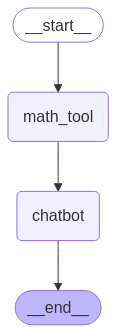

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
# Import message types
from langchain.schema import HumanMessage, AIMessage

# Initialize state with proper message types
state = {"messages": [HumanMessage(content="calculate add 10 5")]}  

# Run the graph
output = graph.invoke(state)

# Print the AI's response
print("AI Response:", output["messages"][-1].content)


TypeError: BaseTool.__call__() takes from 2 to 3 positional arguments but 4 were given

In [1]:
!pip install -q langgraph langchain

from typing import Annotated
from typing_extensions import TypedDict
from langchain.schema import HumanMessage, AIMessage
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Create a simple math tool
@tool("basic_math")
def basic_math_tool(operation: str, a: float, b: float):
    """
    A simple math tool that performs basic operations.
    
    Args:
    - operation (str): The operation (add, subtract, multiply, divide).
    - a (float): The first number.
    - b (float): The second number.

    Returns:
    - dict: Result of the operation or an error message.
    """
    if operation == "add":
        return {"result": a + b}
    elif operation == "subtract":
        return {"result": a - b}
    elif operation == "multiply":
        return {"result": a * b}
    elif operation == "divide":
        if b == 0:
            return {"error": "Cannot divide by zero"}
        return {"result": a / b}
    else:
        return {"error": "Invalid operation"}

In [2]:

# Define the state with messages containing 'role' and 'content'
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]



In [3]:
# Initialize the Mistral LLM
llm = init_chat_model("mistral-large-latest", model_provider="mistralai")


In [4]:
# Initialize the graph
graph_builder = StateGraph(ChatState)

In [5]:

# Define the chatbot node
def chatbot(state: ChatState):
    """
    Chatbot function that invokes the math tool if the user asks for a calculation.
    """
    last_message = state["messages"][-1]

    # Ensure the message is from the user
    if isinstance(last_message, HumanMessage):
        message = last_message.content.lower()

        # Check if the message asks for a calculation (e.g., "calculate add 10 5")
        if "calculate" in message:
            try:
                # Extract the operation and numbers
                _, operation, a, b = message.split()
                a, b = float(a), float(b)  # Convert to float
                
                # Invoke the math tool correctly
                result = basic_math_tool({"operation": operation, "a": a, "b": b})

                # Prepare the response
                if "result" in result:
                    response = f"Result: {result['result']}"
                else:
                    response = result['error']
            except (ValueError, IndexError):
                response = "Invalid input. Use format: 'calculate add 10 5'."
        else:
            # If it's not a calculation request, use the LLM to process the message
            response = llm.invoke([{"role": "user", "content": message}])

    else:
        response = "I can only respond to text messages."

    return {"messages": [AIMessage(content=response)]}

In [6]:

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)


In [7]:
# Set the entry point for the graph
graph_builder.set_entry_point("chatbot")

In [8]:
# Compile the graph
graph = graph_builder.compile()


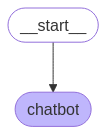

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# Initialize the state with a user message
state = {"messages": [HumanMessage(content="calculate add 10 5")]}
# Run the graph
output = graph.invoke(state)

# Print the AI response
print("AI Response:", output["messages"][-1].content)